In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scvi
import sys
import os

In [2]:
dd = '/home/ql312/rds/rds-turco-lab4-oIhPyuXA8U8/raw_data/trophoblast_organoid_from_Sanger'
sp1 = ['6044STDY864056' + str(i+1) for i in range(6)]
sp2 = ['Pla_Camb101239' + str(i) for i in range(28, 36, 1)]
sps = sp1 + sp2
dd2 = '/home/ql312/rds/hpc-work/tropho_organoid_EVT'

Cells that were 1) having > 20% of mitochondria genes; 2) unassigned to a donor or assigned to multiple donors by Souporcell; 3) falling within the doublet-enriched clusters were excluded from the downstream analysis.

In [3]:
adatas = []
for ff in sps:
    adata = sc.read_10x_mtx(f'{dd}/{ff}/cellranger_res/{ff}/outs/filtered_feature_bc_matrix/')
    info = pd.read_csv(f'{dd2}/sample_info_{ff}.csv', index_col=0)
    print(np.all(adata.obs_names == info.index))
    ind = (info['pct_counts_mt'] < 20) & (info['ID']!='unassigned') & (~info['doublet_local_pred'])
    adata = adata[ind, :]
    info = info[ind]
    adata.obs = info
    adatas.append(adata)
adata = adatas[0].concatenate(adatas[1:], batch_categories=sps)

True
True
True
True
True
True
True
True
True
True
True
True
True
True


Filter out genes detected in less than 20 cells and select the highly variable genes.

In [4]:
sc.pp.filter_genes(adata, min_cells=20)
adata.raw = adata
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, layer='counts', n_top_genes=2000, flavor='seurat_v3', batch_key='ID', subset=True)

/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


Run scVI based on all cells.

In [5]:
scvi.data.setup_anndata(adata, layer="counts", batch_key="ID")
vae = scvi.model.SCVI(adata, n_latent=10)
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata, min_dist=0.3)

INFO     Using batches from adata.obs["ID"]                                                  
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 94752 cells, 2000 vars, 6 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 84/84: 100%|██████████| 84/84 [1:01:24<00:00, 43.75s/it, loss=992, v_num=1]   


Visualize trophoblast and proliferating marker genes.

... storing 'status' as categorical
... storing 'assignment' as categorical
... storing 'sample' as categorical
... storing 'timepoint' as categorical
... storing 'activation_status' as categorical
... storing 'media' as categorical
... storing 'ID' as categorical
... storing 'leiden_sub' as categorical
... storing 'feature_types' as categorical


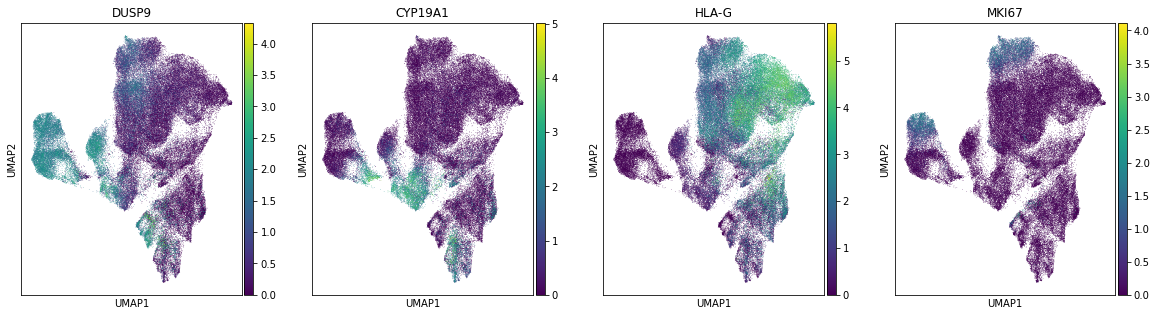

In [6]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 5))
for i, gg in enumerate(['DUSP9', 'CYP19A1', 'HLA-G', 'MKI67']):
    sc.pl.umap(adata, color=gg, show=False, ax=axs[i], use_raw=False)
plt.show()

Check the number of genes detected in each cell. For each type of trophoblast cells, there were clusters of cells which were isolated from their corresponding cell types in the UMAP and had a much lower number of genes detected.

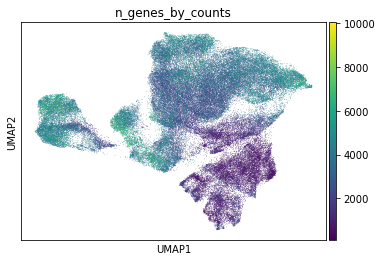

In [7]:
sc.pl.umap(adata, color='n_genes_by_counts')

Annotate each Leiden cluster based on known trophoblast marker genes.

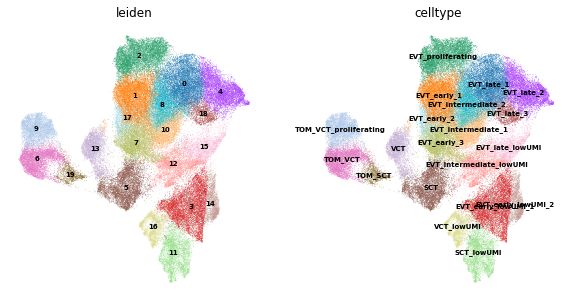

In [8]:
new_nms = [
        'EVT_late_1', 'EVT_early_1', 'EVT_proliferating', 'EVT_early_lowUMI_1', 'EVT_late_2', 'SCT', 'TOM_VCT',
        'EVT_early_3', 'EVT_intermediate_2', 'TOM_VCT_proliferating', 'EVT_intermediate_1', 'SCT_lowUMI',
        'EVT_intermediate_lowUMI', 'VCT', 'EVT_early_lowUMI_2', 'EVT_late_lowUMI', 'VCT_lowUMI', 'EVT_early_2',
        'EVT_late_3', 'TOM_SCT']
adata.obs['celltype'] = adata.obs['leiden'].copy()
adata.rename_categories('celltype', new_nms)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
for i, pp in enumerate(['leiden', 'celltype']):
    sc.pl.umap(adata, color=pp, legend_loc='on data', legend_fontsize=7, show=False, ax=axs[i], frameon=False)

Unsupervised hierarchical clustering of all cell types based on the highly variable genes.

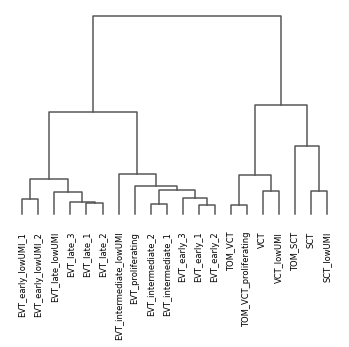

<AxesSubplot:>

In [9]:
sc.tl.dendrogram(adata, var_names=adata.var_names, use_raw=False, groupby='celltype', linkage_method='ward')
sc.pl.dendrogram(adata, groupby='celltype')

Visualize cells from each donor and each time point. The fourth donor failed to be differentiated to EVT.

... storing 'tp' as categorical


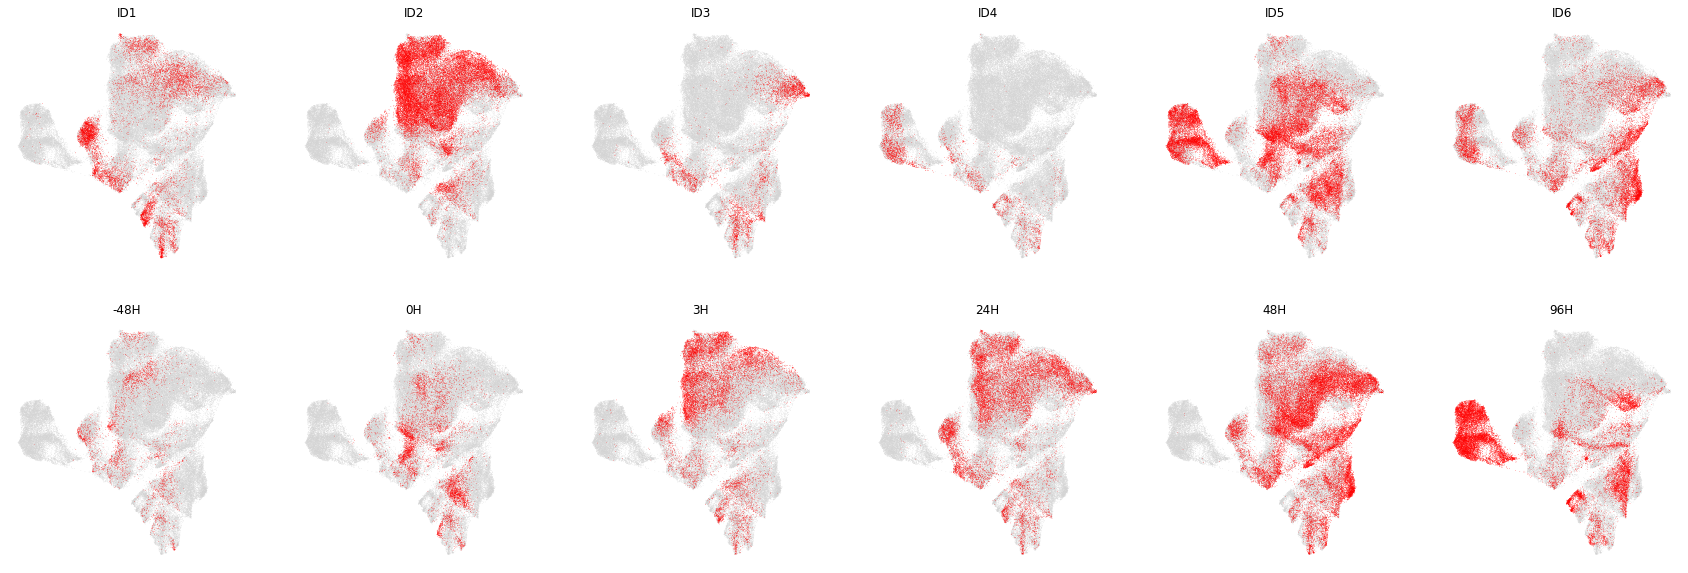

In [10]:
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(30, 10))
##donors
for i, indiv in enumerate([f'ID{j+1}' for j in range(6)]):
    sc.pl.umap(adata, color='ID', groups=[indiv], palette=['red'], title=indiv, legend_loc='none', frameon=False, show=False, ax=axs[0, i])
##time points
adata.obs['tp'] = adata.obs['timepoint'].astype(str)
for i, ti in enumerate(['-48H', '0H', '3H', '24H', '48H', '96H']):
    sc.pl.umap(adata, color='tp', groups=[ti], palette=['red'], title=ti, legend_loc='none', frameon=False, show=False, ax=axs[1, i])

The clusters with low number of genes detected, together with the cells from the fourth donor which failed to be differentiated to EVT, were excluded from the following analysis. The data integration was re-conducted using scVI.

In [11]:
adata = adata.raw.to_adata()
##filtering cells with low UMI and from donor 4
ind1 = adata.obs['celltype'].str.contains('lowUMI').values
ind2 = (adata.obs['ID'] != 'ID4')
ind = ((~ind1) & ind2)
adata = adata[ind, :].copy()
print(adata.shape)
sc.pp.filter_genes(adata, min_cells=20)
adata.raw = adata
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, layer='counts', n_top_genes=1000, flavor='seurat_v3', batch_key='ID', subset=True)

##run scVI
scvi.data.setup_anndata(adata, layer="counts", batch_key="ID")
vae = scvi.model.SCVI(adata, n_latent=10)
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

(67996, 23049)


/home/ql312/software/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


INFO     Using batches from adata.obs["ID"]                                                  
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 67996 cells, 1000 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 118/118: 100%|██████████| 118/118 [32:25<00:00, 16.39s/it, loss=605, v_num=1]


... storing 'feature_types' as categorical


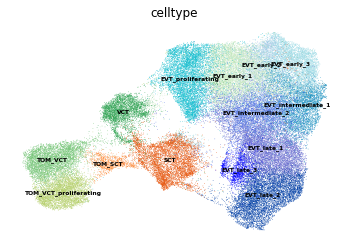

In [12]:
##re-color the cells and visualize them in UMAP
nlvs = ['TOM_VCT_proliferating', 'TOM_VCT', 'VCT',
        'TOM_SCT', 'SCT',
        'EVT_proliferating', 'EVT_early_1', 'EVT_early_2', 'EVT_early_3',
        'EVT_intermediate_1', 'EVT_intermediate_2',
        'EVT_late_1', 'EVT_late_2', 'EVT_late_3']
adata.obs['celltype'].cat.reorder_categories(nlvs, inplace=True)

##re-color the cells
from matplotlib import colors, cm
cols = list(map(colors.to_hex, cm.tab20.colors))
cols2 = list(map(colors.to_hex, cm.tab20b.colors))
cols3 = list(map(colors.to_hex, cm.tab20c.colors))
adata.uns['celltype_colors'] = ([cols2[6]] + [cols3[9]] + [cols3[8]] +
                                [cols3[5]] + [cols3[4]] +
                                [cols[18]] + [cols3[11]] + [cols[1]] + [cols[19]] +
                                ['#1d91c0'] + ['#4a6fe3'] +
                                [cols2[2]] + ['#023fa5'] + ['#0000ff'])

##visualize the cells in UMAP
sc.pl.umap(adata, color='celltype', legend_loc='on data', legend_fontsize=6, frameon=False)

##write out the data
adata.write('HVG_1000_latent_10_after_qc.h5ad')

Check the expression of marker genes across the cell types.

... storing 'feature_types' as categorical


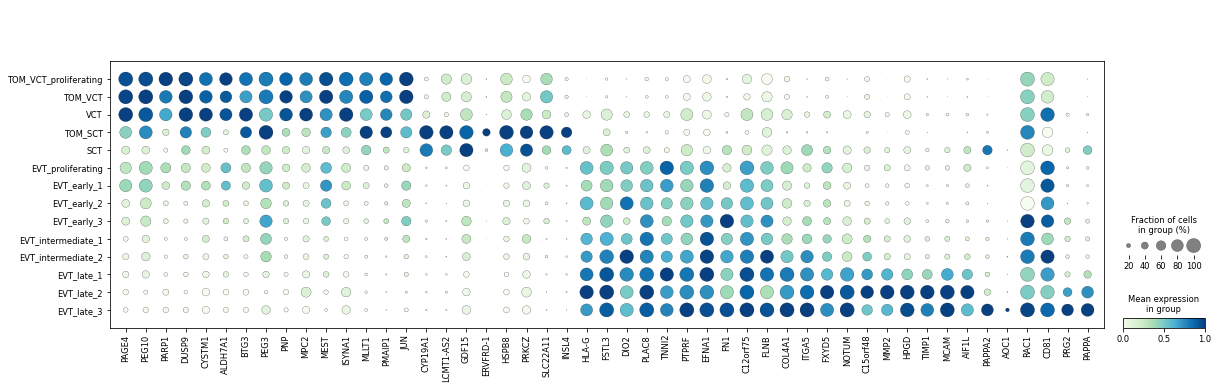

In [13]:
adata = adata.raw.to_adata()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
vct_mk = ['PAGE4', 'PEG10', 'PARP1', 'DUSP9', 'CYSTM1', 'ALDH7A1', 'BTG3', 'PEG3', 'PNP', 'MPC2', 'MEST', 'ISYNA1', 'MLLT1', 'PMAIP1', 'JUN']
sct_mk = ['CYP19A1', 'LCMT1-AS2', 'GDF15', 'ERVFRD-1', 'HSPB8', 'PRKCZ', 'SLC22A11', 'INSL4']
evt_mk = ['HLA-G', 'FSTL3', 'DIO2', 'PLAC8', 'TNNI2', 'PTPRF', 'EFNA1', 'FN1', 'C12orf75', 'FLNB', 'COL4A1', 'ITGA5', 'FXYD5', 'NOTUM', 'C15orf48', 'MMP2', 'HPGD', 'TIMP1', 'MCAM', 'AIF1L', 'PAPPA2', 'AOC1', 'RAC1', 'CD81', 'PRG2', 'PAPPA']
ggs = vct_mk + sct_mk + evt_mk

sc.pl.dotplot(adata, ggs, groupby='celltype', standard_scale='var', cmap='GnBu', categories_order=nlvs)